# Analysis of factors impacting the survival on Titanic

This analysis aims to find clues about factors influencing the survival of passengers on Titanic. The data set used in the analysis only contains information about 891 passengers out of 2224 passengers and crew. Therefore, **all passengers** mentioned in the analysis below actually stands for the 891 passengers. 

Here is the structure of this analysis:   

1. Import data
2. Basic understanding about the data using statistics and graphs
3. Who can survive? -- analysis from different perspects to find factors affecting the survival:
  * Policy
    - What's the impact of the policy that **first save women, children and upper class passenger**? 
  * Wealth
    - Were passengers paying higher fares more likely to survive?
  * Location of cabin
    - Is the survival rate higher for those closer to the boat deck?
  * Family member
    - Were passengers with family aborad more likely to survive? What are the influence of family members? 
  * Hometown
    - Does embarked place affect the survival?
4. Summary
5. Appendix
  * Data wrangling
  * Summary according to the number of members in the family
  * Calculate how many 2-people family are spouse
  * Calculate $\chi^2$ statitstics on survivals

** note: the statistical tests done in the analysis were expressed as the form:**
> t-test: t(degree-of-freedom) = t-value, p = p-value

> $\chi^2$: $\chi^2$(degree-of-freedom, N = number-of-total-sample) = value-of-chi-square, p = p-value

# Import data 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
%matplotlib inline
filename = 'titanic-data.csv'

In [2]:
df = pd.read_csv(filename)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Basic understanding about the data

## Statistics of 'Survived', 'Age', 'SibSp', 'Parch', 'Fare':

In [3]:
df.describe()[['Survived','Age','SibSp','Parch','Fare']]

,Survived,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,32.204208
std,0.486592,14.526497,1.102743,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200


## Distribution of 'Pclass', 'Sex', 'Embarked', 'Deck':
### We can get the information about Deck from Cabin data. The first character of cabin shows the deck.  

[<matplotlib.text.Text at 0x10ccdbed0>, <matplotlib.text.Text at 0x10cd934d0>]

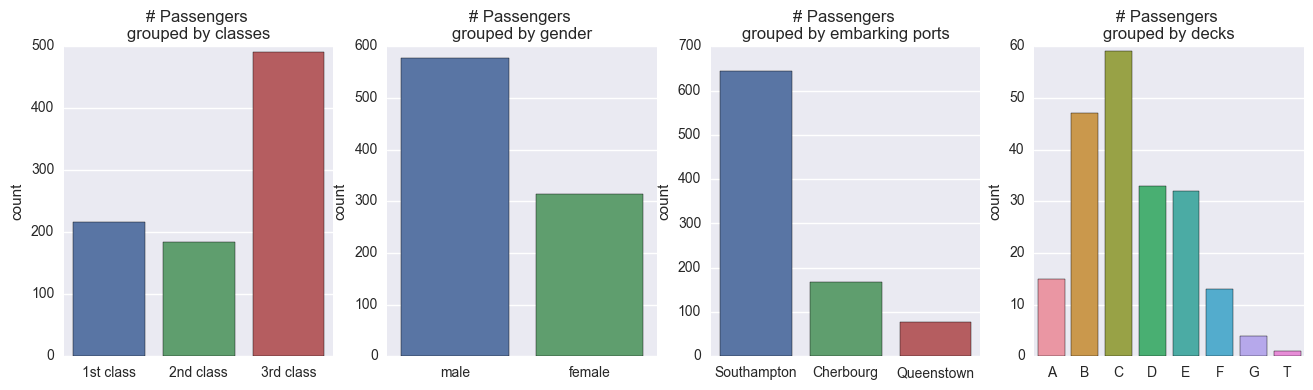

In [4]:
# Create more descriptive labels for Column "Survived", "Pclass", "Embarked":
df['Survival'] = df.Survived.map({0 : 'Died', 1 : 'Survived'})
df['Class'] = df.Pclass.map({1: "1st class", 2 : "2nd class", 3 : "3rd class"})
df['Ports'] = df.Embarked.map({'S' : 'Southampton', 'Q' : 'Queenstown', 'C' : 'Cherbourg'})

### plot 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(16,4))
## Pclass
g = sns.countplot(x='Class',order=['1st class','2nd class','3rd class'],data=df, ax=ax1)
g.set(xlabel='',title='# Passengers \ngrouped by classes')
## Sex
g = sns.countplot(x='Sex',data=df, ax=ax2)
g.set(xlabel='',title='# Passengers \ngrouped by gender')
## Embarked
g = sns.countplot(x='Ports', data=df, ax=ax3)
g.set(xlabel='',title='# Passengers \ngrouped by embarking ports')
## Deck
df['Deck'] = df['Cabin'].str[0]
g = sns.countplot(x='Deck', order=['A','B','C','D','E','F','G','T'], data=df, ax=ax4)
g.set(xlabel='',title='# Passengers \ngrouped by decks')

# Who can survive?
## Policy
What's the impact of the policy that **first save women, children and upper class passenger [[1]](https://en.wikipedia.org/wiki/RMS_Titanic) **? 

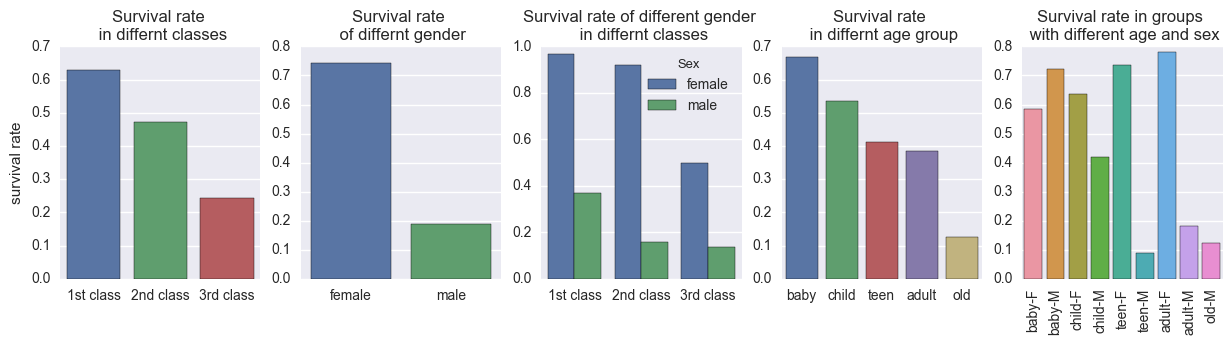

In [5]:
## calculate the mean survival in different classes
clss_alive = df[['Class','Survived']].groupby('Class',as_index=False).mean()
## calculate the mean survival for different sex
sex_alive = df[['Sex','Survived']].groupby('Sex',as_index=False).mean()
## also check if feamle survival rate depends on the class
classSex_alive = df[['Class','Sex','Survived']].groupby(['Class','Sex'], as_index=False).mean()

## only analyze those having Age data
df_age = df.copy()[~df['Age'].isnull()]

##### create new field: 'Age_group' #####
## use "Age_group" to define different age group:
## two different ways to define:
## (1) baby(0<age<=3), child(3<age<=18), adult(18<age<65), old(age>=65)  
## (2) baby(0<age<=3), child(3<age<=13), teen(13<age<=18) ,adult(18<age<65), old(age>=65)
## you can change the definition simply by modifying "age_cut" and "age_labels" to see how the results would change
age_cut = [0,3,13,18,65,200]
age_labels = ['baby','child','teen','adult','old']
df_age['Age_group'] = pd.cut(df_age['Age'],age_cut,labels=age_labels)

##### create new field: 'AgeSex' #####
## use 'AgeSex' to also consider both Age and Sex
df_age['AgeSex'] = df_age['Age_group'].str.cat(df_age.Sex.str[0].str.upper(), sep='-')
Sex_labels = ['F','M']
# the labels in labels_AgeSex
labels_AgeSex = ['{0}-{1}'.format(age_labels[i],Sex_labels[j]) for i in range(len(age_labels)) for j in range(len(Sex_labels))]
# remove labels did not appear in the data 
labels_AgeSex = [labels_AgeSex[i] for i, a in enumerate(labels_AgeSex) if a in df_age['AgeSex'].unique()]

## calculate the mean survival of different Age_group
df_age[['Age_group','Survived']].groupby('Age_group', as_index=False).mean()
## calculate the mena survival of different AgeSex
df_age[['AgeSex','Survived']].groupby('AgeSex', as_index=False).mean()

## plot
fig, (axis1,axis2,axis3,axis4,axis5) = plt.subplots(1,5,figsize=(15,3))
# effect of class
g = sns.barplot(x='Class',y='Survived',data=clss_alive, ax=axis1)
g.set(xlabel='',ylabel='survival rate',title='Survival rate \n in differnt classes')
# effect of sex
g=sns.barplot(x='Sex',y='Survived',data=sex_alive, ax=axis2)
g.set(xlabel='',ylabel="",title='Survival rate \n of differnt gender')
# also check if feamle survival rate depends on the class
g=sns.barplot(x='Class', y ='Survived', data=classSex_alive, hue='Sex',ax=axis3)
g.set(xlabel='',ylabel="",title='Survival rate of different gender \n in differnt classes')

# effect of age
g=sns.barplot(x='Age_group',y='Survived',data=df_age, ci=None, order=age_labels, ax=axis4)
g.set(xlabel='',ylabel="",title='Survival rate \n in differnt age group')
# effect of age and sex
g=sns.barplot(x='AgeSex', y='Survived', order=labels_AgeSex, ci=None, data=df_age, ax=axis5)
g.set_xticklabels(labels_AgeSex, rotation=90)
g.set(xlabel='',ylabel="",title='Survival rate in groups \n with different age and sex')


** Passengers from higher classes apparently show higher survival ($\chi^2(2,N=891)=102.89, p<.001$). The extreme survival difference between female and male strongly support the existence of the policy ($\chi^2(1,N=891)=260.72, p<0.001$). We can further see this effect from the observation that a woman in 3rd class is more likely to survive than a man in 1st class ($\chi^2(1,N=266)=4.09, p<.05$).  Besides women, the policy also emphesize to save children. The survival indeed decreases in groups with older age ($\chi^2(4,N=714)=14.90, p<.005$). If we further consider the gender in different age groups, you can see: **
1. The survival of baby is independent of their gender. This is not so surprising especially as it's difficult to tell the gender of baby. 
2. The survival of male children is a bit lower than that of female children. As children look maturer and adults might be quite alike, male children might be misrecognized as adult as lost the chance to be saved. 
3. From teenagers on, the significant difference of survival between male and female appears.
4. Old male passengers also show very low survival. Besides the fact that their priority on lifeboat is low, they probably not strong enough to survive the cold. No old-F is shown because there are no data about old female passengers.

## Wealth
Survival rate from 1st class is higher than other classes. Were passengers paying higher fares more likely to survive?  

[<matplotlib.text.Text at 0x111115f90>, <matplotlib.text.Text at 0x1111410d0>]

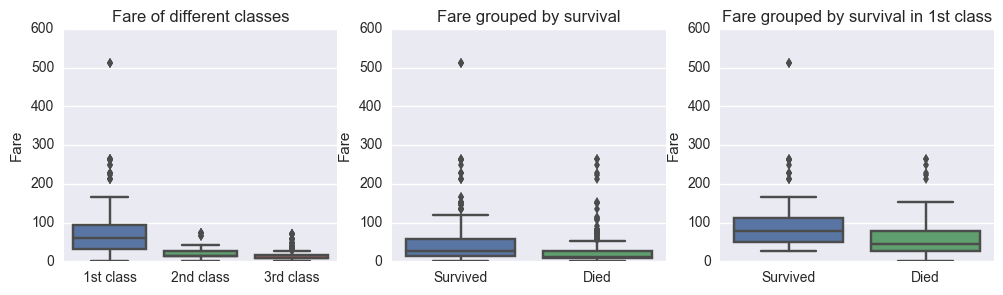

In [6]:
# plot
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,3))
g = sns.boxplot('Class','Fare',data=df,order=['1st class','2nd class','3rd class'], ax=ax1)
g.set(xlabel='',title='Fare of different classes')
g = sns.boxplot(x='Survival',y='Fare',data=df[['Fare','Survival']],order=['Survived','Died'],ax=ax2)
g.set(xlabel='',title='Fare grouped by survival')
class1 = df.loc[df['Pclass']==1,['Survival','Fare']]
g = sns.boxplot(x='Survival',y='Fare',data=class1,order=['Survived','Died'],ax=ax3)
g.set(xlabel='',title='Fare grouped by survival in 1st class')

** The fare of 1st passengers is much higher than the fare of 2nd and 3rd classes (both p-value $<.001$ between 1st class fare and 2nd/3rd class fare). To validate if the higher fare is associated with the higher survival of passengers, I further examined the fare distribution of survived and dead passengers.  The mean fare significantly differs between survived and dead passengers in all classes (t(889)=6.84,$p<.001$) and within 1st class (t(214)=3.10, $p<.005$). However, fare cannot account for the survival of 2nd and 3rd class. The survival of is 2nd significantly higher than 3rd class ($\chi^2(1,N=675)=32.45, p<.001$) but the fares are similar (t(673)=6.22, $p<.001$), suggesting the existence of other survival determining factors. **

## Location of Cabin

[<matplotlib.text.Text at 0x111696710>, <matplotlib.text.Text at 0x111680790>]

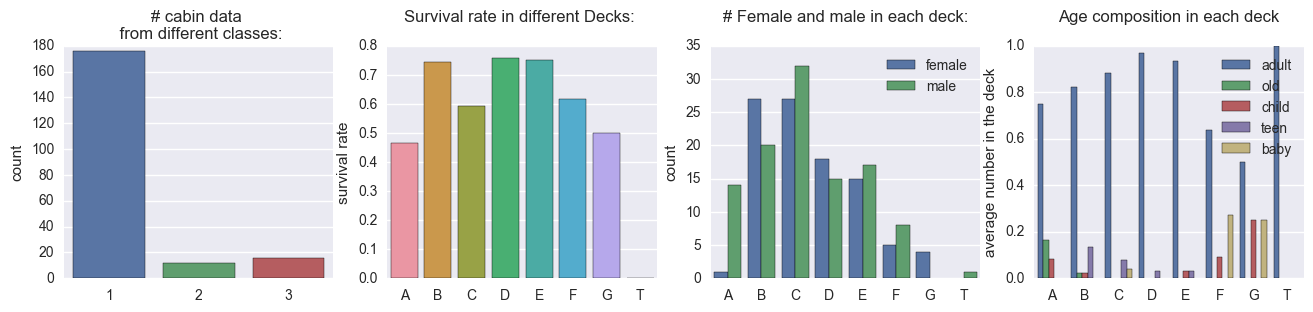

In [7]:
## only analyze those having Cabin data
df_cabin = df.copy()[~df['Cabin'].isnull()]

## calculate the mean survival of each deck
deck_alive = df_cabin[['Deck','Survived']].groupby('Deck',as_index=False).mean()
## calculate the number of females and males in each dock
cabin_sex = df_cabin[['Deck','Sex','Name']].pivot_table(index='Deck',columns='Sex',aggfunc='count')
cabin_sex = cabin_sex.stack(level=-1).reset_index()
## calculate the age composition in each deck
df_age_cabin = df_age.loc[~df_age['Deck'].isnull(),['Age_group','Name','Deck']]
cabin_age_percent = df_age_cabin.groupby('Deck')['Age_group'].value_counts(normalize=True).rename('percentage').reset_index()

# plot
fig, (ax1,ax2,ax3, ax4) = plt.subplots(1,4, figsize=(16,3))
g = sns.countplot(x='Class', data=df_cabin, ax=ax1)
g.set(xlabel='',title='# cabin data \n from different classes:',xticklabels=[1,2,3])

g = sns.barplot(x='Deck', y='Survived', data=deck_alive, ax=ax2)
g.set(xlabel='',ylabel='survival rate',title='Survival rate in different Decks: \n')

g = sns.barplot(x='Deck',y='Name',hue='Sex',data=cabin_sex,ax=ax3)
g.set(xlabel='',title='# Female and male in each deck:\n')
g.legend(loc='upper right')
g.set(xlabel='',ylabel='count')

g = sns.barplot(x='Deck',y='percentage',hue='Age_group',data=cabin_age_percent, ax=ax4)
g.set(xlabel='',title='Age composition in each deck\n')
g.legend(loc='upper right')
g.set(xlabel='',ylabel='average number in the deck')

** The decks from top to bottom of the boat are: boat deck, A, B, C till G. Deck G is the lowest deck that carries passenger[[1]](https://en.wikipedia.org/wiki/RMS_Titanic),[[2]](https://www.encyclopedia-titanica.org/titanic-deckplans/profile.html). It's worth to mention that only 204 passengers had Deck information and >90% of them came from 1st class passengers so the analysis might not be able to present the whole truth. **

** To my surprise, the deck closest to the boat deck (deck A) shows the lowest survival rate. This can be explained by the extreme low number of females on deck A (1 out of 15). This observation again reflects the higher saving priority of women over 1st class passengers. It's not clear to me why deck C shows lower survival rate than deck D and E, as deck C,D and E all show similar age and gender composition. However, the $\chi^2$ statistics shows the the differences of survival rate in different decks are actually not significant ($\chi(6,N=203)=8.33, p=0.21$).  A more complete data set could shed more light in the role of cabin location.**


## Family effect

### If having family members aboard helps survival:

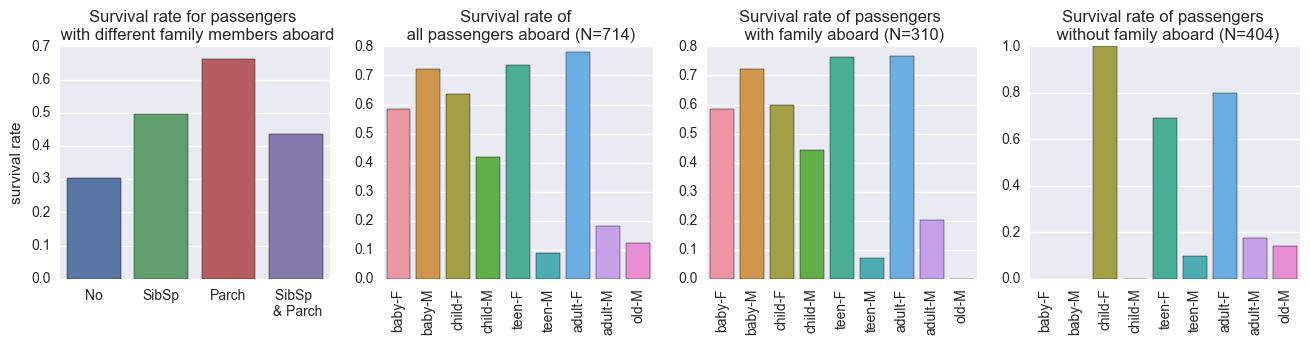

In [8]:
## create a field "Family" to describe if passengers having family aboard
df['Family'] = None
df.loc[((df['SibSp']>0)&(df['Parch']==0)),'Family'] = 'SibSp'
df.loc[((df['SibSp']==0)&(df['Parch']>0)),'Family'] = 'Parch'
df.loc[((df['SibSp']>0)&(df['Parch']>0)),'Family'] = 'Both'
df.loc[((df['SibSp']==0)&(df['Parch']==0)),'Family'] = 'No'
family_alive = df[['Family','Survived']].groupby('Family',as_index=False).mean()

## Create a data frame 'df_family' only consist of people with family members
## and since I are going to analyze the composition of the family, I only analyzed data with age information
df_family = df_age.copy()[((df_age['SibSp']>0)|(df_age['Parch']>0))]

## plot
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(16,3))

# efect of having family
g = sns.barplot(x='Family',y='Survived', order=['No','SibSp','Parch','Both'],data = family_alive, ax=ax1)
g.set(xlabel='',ylabel='survival rate',title='Survival rate for passengers \n with different family members aboard')
g.set(xticklabels=['No','SibSp','Parch','SibSp \n & Parch',])

# effect of age and sex
g=sns.barplot(x='AgeSex', y='Survived', order=labels_AgeSex, ci=None, data=df_age, ax=ax2)
g.set_xticklabels(labels_AgeSex, rotation=90)
g.set(xlabel="",ylabel="")
g.set(title='Survival rate of \n all passengers aboard'+' (N='+str(len(df_age))+')')

# survival rate for passengers with family in different AgeSex group
ageSexF_alive = df_family[['AgeSex','Survived']].groupby('AgeSex',as_index=False).mean()
g = sns.barplot(x='AgeSex',y='Survived', order=labels_AgeSex, data=ageSexF_alive, ax=ax3)
g.set_xticklabels(labels_AgeSex, rotation=90)
g.set(xlabel="",ylabel="")
g.set(title='Survival rate of passengers \n with family aboard'+' (N='+str(len(df_family))+')')

# survival rate for passengers without family in different AgeSex group
df_noFamily = df_age.copy()[((df_age['SibSp']==0)&(df_age['Parch']==0))]
ageSex_alive = df_noFamily[['AgeSex','Survived']].groupby('AgeSex',as_index=False).mean()
g = sns.barplot(x='AgeSex',y='Survived', order=labels_AgeSex, data=ageSex_alive, ax=ax4)
g.set_xticklabels(labels_AgeSex, rotation=90)
g.set(xlabel="",ylabel="")
g.set(title='Survival rate of passengers \n without family aboard'+' (N='+str(len(df_noFamily))+')')




** Having family on board can help the survival ($\chi^2(3,N=891)=47.0,p<.001$). The main increases of survival in babies and children are due to the fact that baby and child usually are accompanied by their family (only 3 children are alone aboard, with ages of 5, 11 and 13). Even adults and teenagers can survived better. 
The different trends observed for `child-F` and `old-M` was caused by limited data points: 2 out 2 `child-F` were survived, the survival rate increses to 100%. 1 out 1 `old-M` died, lead to 0% of survival in the family case. **

### Connect family member:
1. Find Family name and née. 
2. Create a family id `Fid` to link people from the same family (or with relations we can trace), based on:
  - **same ticket number**. People shared the same ticket number but have different surname are probably friends, relatives from the mother side, housekeeper... no matter what, they know each other. So here I group them as the same family.
  - **shared family name or nee**. Women change their family name after marriage. With neé we can link relatives from the mothers' side.

In [9]:
def get_familyName(name):
    fn = re.compile(r'([\w\-]+)\,')
    return re.findall(fn, name)[0]
   
def get_nee(name):
    ori = re.compile(r'(\w+)\,\s[^\(]+\(([\w\s]+)\)')
    out = re.findall(ori,name)
    if out:
        return out[0][1].split(' ')[-1] 
    else:
        return 'No'

## add 'Fn' to know family name
df_family['Fn'] = df_family['Name'].apply(get_familyName)
## add "Ori_name" to know if original family is also aboard
df_family['nee'] = df_family['Name'].apply(get_nee)


## Add the field "Fid" to group members from the same family together.
# (1): same ticket number
ticket_list = list(df_family['Ticket'].unique())
df_family['Fid'] = 0
for ticket in ticket_list:    
    asign_ID = df_family['Fid'].max()+1
    df_family.loc[df_family['Ticket']==ticket,'Fid']=asign_ID  
    
# (2):shared family name or nee
nee_list = list(df_family.loc[df_family['nee']!='No','nee'].unique())
Fn_list = list(df_family['Fn'].unique())
currentF_id_list = []
nee_id_list = []
for nee in nee_list:
    if nee in Fn_list: # original family also aboard
        # get nee family id
        nee_id = list(df_family.loc[df_family['Fn']==nee,'Fid'])[0] 
        nee_id_list.append(nee_id)
        # get current family id
        currentF_id = list(df_family.loc[df_family['nee']==nee,'Fid'])[0]
        currentF_id_list.append(currentF_id)
# connect the relation
relation_dict = defaultdict(list)
for i, nee_id in enumerate(nee_id_list):
    if nee_id in currentF_id_list:
        relation_dict[str(nee_id)].append(currentF_id_list[i])
# find list of new family
new_family = []
for key, value in relation_dict.iteritems():
    # Find those nee family id is different from their current family id.
    # Those traveled together would have the same nee family id and current family id, 
    # as the family id was first assigned by ticket number
    if key!=str(value[0]): 
        new_family.append([int(key), value[0]]) 
# assign newID to the related family
for n in new_family:
    newID = df_family['Fid'].max()+1
    for oldID in n:
        df_family.loc[df_family['Fid']==oldID,'Fid']=newID

### Overview of Family composition

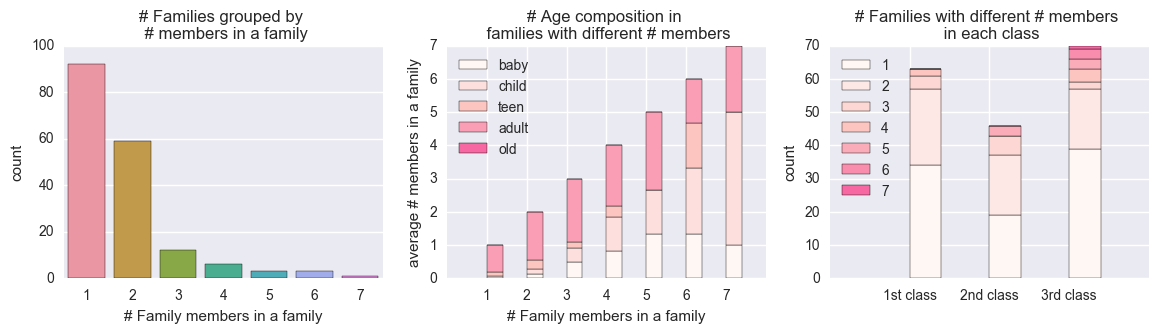

In [10]:
## create a data frame "df_family_Info_summary" to summarize information from different family
Age_group_dummy = pd.get_dummies(df_family['Age_group'])
AgeSex_group_dummy=pd.get_dummies(df_family['AgeSex'])
Embarked_dummy = pd.get_dummies(df_family['Embarked'])
class_dummy = pd.get_dummies(df_family['Pclass'])
sex_dummy = pd.get_dummies(df_family['Sex'])

df_family_Info = df_family.copy().join(Age_group_dummy).join(AgeSex_group_dummy).join(Embarked_dummy).join(class_dummy).join(sex_dummy)
df_family_Info = df_family_Info.drop(['Ticket','Fn','nee','Pclass','Embarked','AgeSex','Age_group','Age','PassengerId','Name','Cabin','Deck','SibSp','Parch'],axis=1)
df_family_Info_summary = df_family_Info.copy().groupby('Fid').sum() 
num_member = df_family_Info[['Fid','Survived']].groupby('Fid').count().rename(columns={'Survived':'num_member'})
df_family_Info_summary = df_family_Info_summary.join(num_member)
df_family_Info_summary['Fare'] = df_family_Info_summary['Fare']/df_family_Info_summary['num_member'].astype(float)
df_family_Info_summary['dummy'] = 1
df_family_Info_summary['CAratio'] = df_family_Info_summary['child']/df_family_Info_summary['adult']
df_family_Info_summary['Survived_rate'] = df_family_Info_summary['Survived']/df_family_Info_summary['num_member']

## create 'df_all_family' to summarize fmailies data according to different number of family members                                                 
df_all_family = df_family_Info_summary.groupby('num_member').sum()
df_all_family = df_all_family.div(df_all_family.dummy,axis='index').reset_index()
pd.set_option('display.precision', 2)

## plot
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(14,3))
# (A) distribution of family numbers
g = sns.countplot(x='num_member',data=df_family_Info_summary,ax=ax1)
g.set(title='# Families grouped by \n # members in a family',xlabel='# Family members in a family')

# (B) composition of family members
x = list(df_all_family['num_member'])
rows = ['baby','child','teen','adult','old']
data = pd.DataFrame.as_matrix(df_all_family[rows]).transpose()
# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.array([0.0] * len(x))
# Plot bars and create text labels for the table
colors = plt.cm.RdPu(np.linspace(0, 0.5, len(rows)))
bar_width = 0.4
plt.subplot(1,3,2)
for row in range(len(data)):
    plt.bar(x, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
plt.xlim(0,8)
plt.xticks(range(1,8))
plt.xlabel('# Family members in a family')
plt.ylabel('average # members in a family')
plt.title('# Age composition in \n families with different # members')
plt.legend(rows,loc='upper left')

# (C) number of families in different classes
# prepare the data for plot
fc = pd.DataFrame(df_family_Info_summary.loc[df_family_Info_summary[1]>0,'num_member'])
fc['class'] = '1st class'
sc = pd.DataFrame(df_family_Info_summary.loc[df_family_Info_summary[2]>0,'num_member'])
sc['class'] = '2nd class'
tc = pd.DataFrame(df_family_Info_summary.loc[df_family_Info_summary[3]>0,'num_member'])
tc['class'] = '3rd class'
cj = pd.concat([fc,sc,tc])
num_dummy = pd.get_dummies(cj['num_member'])
cj = cj.join(num_dummy).drop(num_member,axis=1)
cj_plot = pd.DataFrame.as_matrix(cj.groupby('class').sum()).transpose()
# plot
x = [1,2,3]
rows = [str(a) for a in range(1,8)]
# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.array([0.0] * len(x))
# Plot bars and create text labels for the table
colors = plt.cm.RdPu(np.linspace(0, 0.5, len(rows)))
bar_width = 0.4
ax3 = plt.subplot(1,3,3)
for row in range(len(cj_plot)):
    plt.bar(x, cj_plot[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + cj_plot[row]
plt.xlim(0,4)
plt.xticks(range(1,4))
plt.setp(ax3, xticklabels=['1st class','2nd class','3rd class'])
plt.ylabel('count')
plt.legend(rows,loc='upper left')
plt.title('# Families with different # members \n in each class')

** It looks weird that most of the families only have one family member in our analysis. These passengers indeed showed a non-zero `SibSp` or `Parch` number from the provided Titanic data but it's impossible to trace their family members by family names or ticket numbers. This probably caused by missing data: data without age information was excluded and only 891 passengers out of 2224 passengers and crew existed. **

** To examine further about the composition of family members in different sizes of traveling families, you can see:** 
1. Families with 2 members aborad are mostly adults. 25 out of 59 traveled with their spouses. About 20% of them travel with a kid. 
2. Families with 3-5 members aborad are mostly 2 adults with children. The adults are mostly parents, sometimes probably housekeeper (with different family names).
3. Families with 6 members aborad seems to replace the number of adult with the number of teenages+adult, suggesting the role of teenager in assisting parents. 
4. Only one family with 7 members. 

** Family with more than 3 members mostly traveled with second or third class. The max sizes of families are 4, 5, 7 in 1st, 2nd and 3rd class, respectively.  **




### How family member affects survival 

[<matplotlib.text.Text at 0x11384b6d0>, <matplotlib.text.Text at 0x11387f110>]

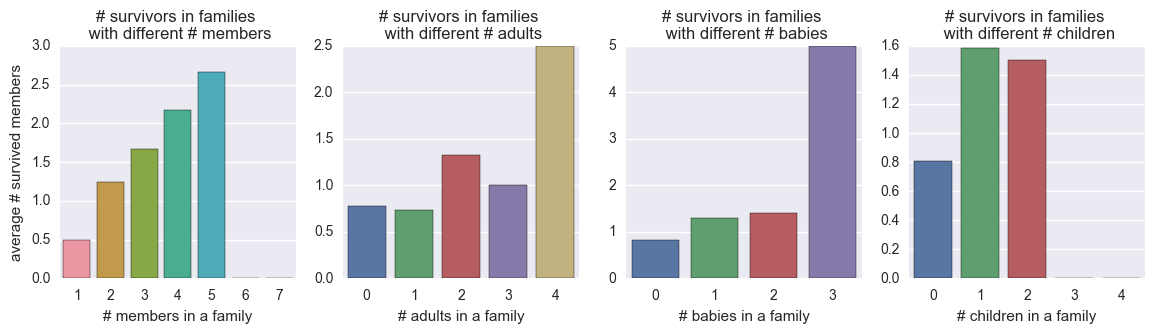

In [11]:
## plot
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(14,3))
# survial vs number of Family Member in one family:
aa = df_family_Info_summary[['num_member','Survived']].groupby('num_member',as_index=False).mean()
g = sns.barplot(x='num_member',y='Survived',data=aa,ax=ax1)
g.set(xlabel='# members in a family')
g.set(ylabel='average # survived members',title='# survivors in families \n with different # members')
# survial vs number of Adult in one family:
aa = df_family_Info_summary[['adult','Survived']].groupby('adult',as_index=False).mean()
g = sns.barplot(x='adult',y='Survived',data=aa,ax=ax2)
g.set(xlabel='# adults in a family')
g.set(ylabel='',title='# survivors in families \n with different # adults')
# survial vs number of baby in one family:
aa = df_family_Info_summary[['baby','Survived']].groupby('baby',as_index=False).mean()
g = sns.barplot(x='baby',y='Survived',data=aa,ax=ax3)
g.set(xlabel='# babies in a family')
g.set(ylabel='',title='# survivors in families \n with different # babies')
# survial vs number of child in one family
aa = df_family_Info_summary[['child','Survived']].groupby('child',as_index=False).mean()
g = sns.barplot(x='child',y='Survived',data=aa,ax=ax4)
g.set(xlabel='# children in a family')
g.set(ylabel='',title='# survivors in families \n with different # children')

**It seems like families with members more than 5 can hardly survive. The number of adults (or male adult) in a family helps increase numbers of survivors in a family but not much, probably still restricted by the policy that women and children are saved first. This can be reflected by the two right figures: increase number of baby and child would increase the number of people survived in a family, but mostly the survived number don't go higher than the number of baby/child. The limited number of observations also lead to extreme high survived members: only 2 data of 4 adults in a family and  only 1 data of 3 babies in a family. **

## Hometown
Here I assume the places people embarked are also the places they came from. This assumption is not so unreasonable in the times that people travel less and many immigrants tried to go to the US.

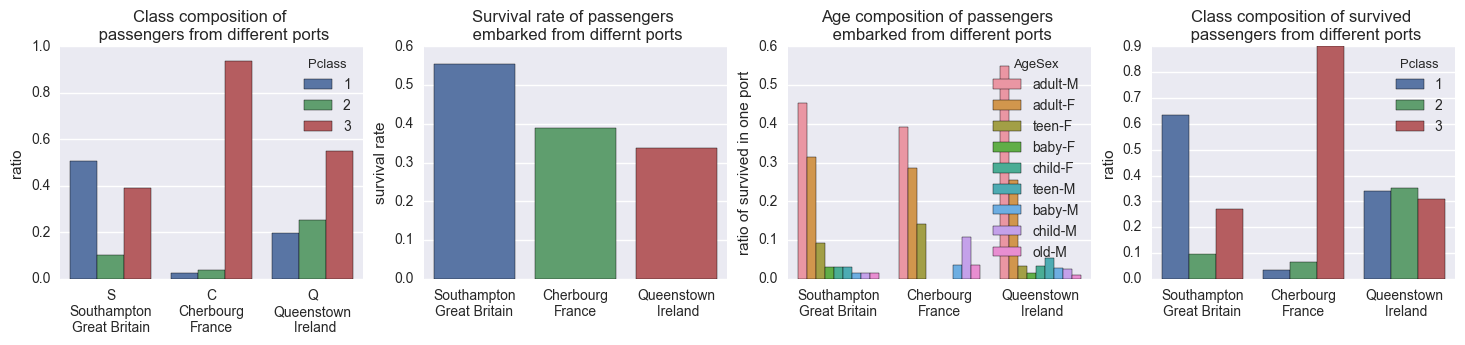

In [12]:
# composition passengers of different classes in different port
embarked_class = df[['Embarked','Pclass','Survived']]
embarked_class_plot = embarked_class.groupby('Embarked')['Pclass'].value_counts(normalize=True).rename('percentage').reset_index()
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(18,3))
g = sns.barplot(x='Embarked',y='percentage',hue='Pclass', data=embarked_class_plot,ax=ax1)
g.set(xticklabels=['S\nSouthampton\nGreat Britain','C\nCherbourg\nFrance','Q\nQueenstown\n Ireland'])
g.set(ylabel='ratio',xlabel='')
g.set(title='Class composition of \n passengers from different ports')

# survival for passengers from different ports
embarked_alive = embarked_class[['Embarked','Survived']].groupby('Embarked',as_index=False).mean()
g=sns.barplot(x='Embarked',y='Survived',data=embarked_alive,ax=ax2)
g.set(xticklabels=['Southampton\nGreat Britain','Cherbourg\nFrance','Queenstown\n Ireland'])
g.set(title='Survival rate of passengers \n embarked from differnt ports',xlabel='')
g.set(ylabel='survival rate')

# composition passengers of different Age in different port
embarked_class = df_age[['Embarked','AgeSex','Survived']]
embarked_class_plot = embarked_class.groupby('Embarked')['AgeSex'].value_counts(normalize=True).rename('percentage').reset_index()
g = sns.barplot(x='Embarked',y='percentage',hue='AgeSex', data=embarked_class_plot,ax=ax3)
g.set(xticklabels=['Southampton\nGreat Britain','Cherbourg\nFrance','Queenstown\n Ireland'])
g.set(ylabel='ratio of survived in one port',xlabel='')
g.set(title='Age composition of passengers \n embarked from different ports')

# composition of classes from survived passengers embarked from diferent ports
embarked_class = df.loc[df['Survived']==1,['Embarked','Pclass','Survived']]
embarked_class_alive = embarked_class.groupby('Embarked')['Pclass'].value_counts(normalize=True).rename('percentage').reset_index()
g = sns.barplot(x='Embarked',y='percentage',hue='Pclass',data=embarked_class_alive,ax=ax4)
g.set(xticklabels=['Southampton\nGreat Britain','Cherbourg\nFrance','Queenstown\n Ireland'])
g.set(ylabel='ratio',xlabel='')
g.set(title='Class composition of survived \n passengers from different ports')

** Most passengers from France and Ireland were in 3rd class, implying they tried to immigrate to the US. Remarkably, the survival rate of passengers embarked from Cherbourg was much higher than the ratio of 1st passengers aborad there. We can see that the high survival rate of passengers embarked from Cherbourg was not due to a higher female nor children composition. This observation might reflect the strong survival will of the immigrants to build a new life in the US. Examination of the classes of survived passengers further supports this theory: 3rd class passengers embarked from Cherbourg shows remarkably high survival rate. ** 

# Summary
** This analysis shows that factors such as being 1st class passengers, having family aborad, embarking from Cherbourg also help increase the surivival, but the main survival factors are _gender_ and _age_. The survival rate of male from 1st is lower than female from 2nd and 3rd class strongly supports class is not the determining factor for boarding the lifeboat. The higher survival rate for 1st class probably benifited from its closer location to the boat deck (_first come, first serve_). **

** Due to the lack of complete passenger data, the analysis might not present the whole truth. In particular, the imcompleted cabin data (only about 25% passengers having cabin data and 90% of them are in 1st class) very likely bias the results about the effects of location on survival. **

 

# Appendix
## Data wrangling
### data frames created in this analysis. The new fields and the definitions are listed: 
1. df_age: only include those having Age data
  * `Age_group`: define different age group
   - values in this field are: 'baby'(0<age<=3), 'child'(3<age<=13), 'teen'(13<age<=18), 'adult'(18<age<65), 'old'(age>=65) [[3]](https://www.healthychildren.org/English/ages-stages/Pages/default.aspx)
   - can be changed simply by modifying parameters `age_labels` & `age_cut`.
  * `AgeSex`: consider both Age and Sex
   - values in this field are 'catergory in `Age_group`-Sex'. F: female, M: male. (e.g., baby-F)
2. df_cabin: only include those having Cabin data
  * `Deck`: first letter in Cabin data
3. df_family: only include those having family merber (SibSp or Parch greter than 0) and with age data
  * `Fn`: family name
  * `nee`: nee, for married women the name is in () after the curreny name
  * `Fid`: id assign to each family
   - based on the same ticket number
   - family before marriage is also linked together  
4. df_family_Info_summary: data of different families
  * `num_member`: number of family member in the analyzed data set (see **note**)
  * `CAratio`: ratio between number of children and number of adults in the family
  * `baby`: number of baby in the family
   - also applies to fields like `child`, `teen`, `adultM`, `adultF`, `female`...
  * `1`: number of 1st class passengers in the family
  * `dummy`: value is 1, just used for processing df_all_family and without meaning
  * `Fare`: average Fare in the family
  * `Survived_rate`: average survival rate in the family
5. df_all_family: summarize family data grouped by the number of member in the family
  * data showing the average value in families with specified number of member 
   - e.g., `teen` in the row of `num_member=1`: average number of teenager for families with 1 member.

** note: Passengers were regarded as having family based on non-zero `SibSp` or `Parch` values. As not all passengers are included in the data set (the data set only contains 891 out of 2224 passengers), the number of family (`num_member`) here actually refers to number of family members in the analyzed data set (including the the passenger himself/herself). **

    

## Summary according to the number of members in the family

In [13]:
df_all_family

,num_member,Survived,Fare,baby,child,teen,adult,old,adult-F,adult-M,...,Q,S,1,2,3,female,male,dummy,CAratio,Survived_rate
0,1,0.50,42.91,0.02,0.05,0.12,0.80,0.00,0.34,0.47,...,0.00,0.66,0.37,0.21,0.42,0.46,0.54,1.0,inf,0.50
1,2,1.24,53.26,0.14,0.14,0.27,1.44,0.02,0.83,0.61,...,0.07,1.46,0.78,0.61,0.61,1.14,0.86,1.0,inf,0.62
2,3,1.67,59.33,0.50,0.42,0.17,1.92,0.00,0.92,1.00,...,0.00,2.25,1.00,1.50,0.50,1.58,1.42,1.0,0.25,0.56
3,4,2.17,81.52,0.83,1.00,0.33,1.83,0.00,1.33,0.50,...,0.00,3.33,1.33,0.00,2.67,2.67,1.33,1.0,0.83,0.54
4,5,2.67,26.23,1.33,1.33,0.00,2.33,0.00,1.67,0.67,...,1.67,3.33,0.00,2.33,2.67,2.00,3.00,1.0,1.08,0.53
5,6,0.00,38.16,1.33,2.00,1.33,1.33,0.00,1.00,0.33,...,0.00,6.00,0.00,0.00,6.00,2.00,4.00,1.0,1.50,0.00
6,7,0.00,31.28,1.00,4.00,0.00,2.00,0.00,1.00,1.00,...,0.00,7.00,0.00,0.00,7.00,5.00,2.00,1.0,2.00,0.00


## Calculate how many 2-people family are spouse 

In [14]:
ana_fid_list=list(df_family_Info_summary.loc[df_family_Info_summary['num_member']==2,'Survived'].reset_index()['Fid'])
ms = re.compile(r'\w+\,\s[Mrs.]+\s([\w\s]+)\s\(.*')
mr = re.compile(r'\w+\,\s[Mr.]+\s([\w\s]+)')

mrList=[]
mr_fidList=[]
for fid in ana_fid_list:
    df_family.loc[df_family['Fid']==fid,'Name']
    for name in df_family.loc[df_family['Fid']==fid,'Name']:
        if re.findall(ms,name):
            mrList.append(re.findall(ms,name)[0])
            mr_fidList.append(fid)
count = 0
for i, fid in enumerate(mr_fidList):
    df_family.loc[df_family['Fid']==fid,'Name']
    for name in df_family.loc[df_family['Fid']==fid,'Name']:
        if re.findall(mr,name):
            if re.findall(mr,name)[0]== mrList[i]:
                count += 1 
print count,' out of ',len(ana_fid_list)

25  out of  59


## Calculate $\chi^2$ statitstics on survivals

In [15]:
### statistics of field influence on survival:
def chi_survival_by(data_frame, group_field):
    chi_survival = data_frame[['Survived',group_field]].groupby(group_field).agg(['count','sum'])
    obs_alive = np.array(chi_survival['Survived','sum'])
    obs_all = np.array(chi_survival['Survived','count'])
    obs_dead = obs_all - obs_alive
    obs = np.array([obs_alive,obs_dead])
    return obs
  
def chi_survival_by_Special_compare(data_frame, dict_field):
    '''
    The imput would be the data_frame and a list of dictionaries 
    with each dictionary specifies each field name and value want to compare
    the keys of each dictionary specify the fields want to compare
    the values of each dictionary specify the value of the field want to compare
    '''
    obs_alive = []
    obs_dead = []
    
    for com in dict_field:
        logic_input = 1
        out_expression = []
        for key, value in com.iteritems():
            logic_input &= (data_frame[key]==value)
            out_expression.append(value)
 
        a = data_frame.loc[logic_input,'Survived']
        print 'N for '," ".join(out_expression),'=', len(a)
        g_alive = a.sum()
        g_dead = len(a)-g_alive
        obs_alive.append(g_alive)
        obs_dead.append(g_dead)
    obs = np.array([obs_alive,obs_dead])
    return obs

def print_chi_survival(obs):    
    chi2, p , deg_f, expected_value = chi2_contingency(obs)
    print 'chi^2:', chi2
    print 'p-value:', p
    print 'degree of freedom:', deg_f
    print 'expected_value:', expected_value 
    print '=============='
    
## 1st male vs 3rd class female
dict_field=[{'Class':'1st class','Sex':'male'},{'Class':'3rd class','Sex':'female'}]
obs = chi_survival_by_Special_compare(df, dict_field)
print_chi_survival(obs)
## 1st male vs 2nd class female
dict_field=[{'Class':'1st class','Sex':'male'},{'Class':'2nd class','Sex':'female'}]
obs = chi_survival_by_Special_compare(df, dict_field)
print_chi_survival(obs)
## 2st vs 3rd class 
dict_field=[{'Class':'2nd class'},{'Class':'3rd class'}]
obs = chi_survival_by_Special_compare(df, dict_field)
print_chi_survival(obs)
## DeckB, DeckA
dict_field=[{'Deck':'B'},{'Deck':'A'},{'Deck':'C'},{'Deck':'D'},{'Deck':'E'},{'Deck':'F'},{'Deck':'G'}]
obs = chi_survival_by_Special_compare(df, dict_field)
print_chi_survival(obs)
## Family: no, both, SibSp, Parch
dict_field=[{'Family':'No'},{'Family':'Both'},{'Family':'SibSp'},{'Family':'Parch'}]
obs = chi_survival_by_Special_compare(df, dict_field)
print_chi_survival(obs)


N for  1st class male = 122
N for  3rd class female = 144
chi^2: 4.0936134474
p-value: 0.0430455229945
degree of freedom: 1
expected_value: [[ 53.66165414  63.33834586]
 [ 68.33834586  80.66165414]]
N for  1st class male = 122
N for  2nd class female = 76
chi^2: 56.4022302738
p-value: 5.90633389184e-14
degree of freedom: 1
expected_value: [[ 70.85858586  44.14141414]
 [ 51.14141414  31.85858586]]
N for  2nd class = 184
N for  3rd class = 491
chi^2: 32.4468638935
p-value: 1.22496478135e-08
degree of freedom: 1
expected_value: [[  56.15407407  149.84592593]
 [ 127.84592593  341.15407407]]
N for  B = 47
N for  A = 15
N for  C = 59
N for  D = 33
N for  E = 32
N for  F = 13
N for  G = 4
chi^2: 8.33215357339
p-value: 0.214764705526
degree of freedom: 6
expected_value: [[ 31.48768473  10.04926108  39.5270936   22.10837438  21.43842365
    8.70935961   2.67980296]
 [ 15.51231527   4.95073892  19.4729064   10.89162562  10.56157635
    4.29064039   1.32019704]]
N for  No = 537
N for  Both = 142
